<a href="https://colab.research.google.com/github/BenYavor/MA_GAN/blob/master/MA_GAN_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0-rc0
!pip install -q pyyaml h5py
#!pip install -q tf_nightly
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
tf.__version__
from tensorflow import keras
import time

## System funktionsweise Allgemeine Daten

#### Rauschen
genarats-> **shape**: batch_size * number_of_real_channels_uses_per_message \\
and does a average power normalization


#### Generator
Eingang: (2*n,32)  ; Ausgang: (32,n)   \\
Loss-Function:

#### Discriminator
Eingang: (2*n,32)  ; Ausgang: (32,1)  \\
Loss-Function:


#### Training


###Systemparameter
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses **What is meant by that??** \\
$N$ - Länge des Rauschvektors

In [0]:
n = 2 
k = 2       # Number of information bits per message, i.e., M=2**k
M = 2**k      # Number of real channel uses per message
seed = 2    # Seed RNG reproduce identical results
D_nb_weights = 32
G_nb_weights = 32


batch_size = 10000   #100


x = tf.random.normal((batch_size,n))    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )

## Generator Model

In [0]:
randN_initial = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

In [4]:


#def generator(x):
    # Concatenate z and y
#    G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32)  #create noise directly within the generator  
#    inputs = tf.concat(values=[x, G_n], axis=1)
    #dense NN
#    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
#    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)
#    G_lin = tf.matmul(G_h2, G_W3) + G_b3
    #G_prob = tf.nn.sigmoid(G_lin)
#    return G_lin

def generator_noise(input):
  G_n = tf.random.normal([tf.shape(input)[0],n],dtype=tf.float32)  #create noise directly within the generator  
  inputs = tf.concat(values=[input, G_n], axis=1)
  return inputs
    
def generator(x = tf.keras.Input(shape=(batch_size,n)),training = False):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Lambda(generator_noise))
  model.add(tf.keras.layers.Dense(32,use_bias=True,activation='relu'))#, input_shape=(2*n,))
  model.add(tf.keras.layers.Dense(32,use_bias=True, activation='relu'))
  model.add(tf.keras.layers.Dense(n,use_bias=False, activation='sigmoid'))
  return model

generator= generator()
test = generator(x)
print(test[1])

tf.Tensor([0.4325048 0.5320561], shape=(2,), dtype=float32)


### Help Functions

In [0]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

#numpy version of kl divergence
def kl_divergence_np(p, q):
    #use "Laplace correction" w to avoid zero and inf
    w=1e-5
    p = p + w
    q = q + w
    return np.sum(p * np.log(p / q))

#tensorflow version of kl divergence
def kl_divergence_tf(p, q):
    #use "Laplace correction" w to avoid zero and inf
    w = 1e-5
    p = p + w
    q = q + w
    return tf.reduce_sum(p * tf.log(p / q))

## Channels as Black-Box

In [0]:
train_SNR_dB = 8
noise_std = EbNo2Sigma(train_SNR_dB)

def real_channel(x):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

    #Rayleigh
    #return x + tf.sqrt(tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

    


## Discriminator
Model definition and creating discriminator


In [0]:
def concc(y,x):  
  inputs = tf.concat(values=[y,x], axis=1)
  return inputs

def get_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=True, activation='relu',input_shape=((2*n,))))
  model.add(tf.keras.layers.Dense(1,use_bias=False, activation='sigmoid'))
  return model
discriminator = get_discriminator()

#def discriminator(y,x):
#    # Concatenate x and y
#    inputs = tf.concat(values=[y,x], axis=1)
#    #dense NN
#    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
#    D_logit = tf.matmul(D_h1, D_W2) + D_b2
#    D_prob = tf.nn.sigmoid(D_logit)
#    return D_prob, D_logit

## Data Generation, überhaupt noch relevant??!!

## discriminator desicion????


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Define Loss
strongly inspiered by: \\
https://www.tensorflow.org/beta/tutorials/generative/dcgan?hl=en

## defining Loss. TODO:
compile the Model with the right loss functions

In [9]:
x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
real_training_data = tf.concat(values=[real_channel(x), x], axis=1)  
fake_training_data = tf.concat(values=[generator(x, training =True),x], axis=-1)

print(real_training_data.shape,fake_training_data.shape)
real_output = discriminator(real_training_data)
fake_output = discriminator(fake_training_data)
print(fake_output[1])
#print(real_output, fake_output)

(10000, 4) (10000, 4)
tf.Tensor([0.5223961], shape=(1,), dtype=float32)


In [0]:
def discriminator_loss(real_output, fake_output):
  loss= -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
  return loss
  
def generator_loss(fake_output, generator):
  loss = -tf.reduce_mean(tf.math.log(fake_output))
  return loss


# Learning Rate

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)           #RMSprop   in oreder to test where the error comes from
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)      #

# Evaluation with Histogram

In [0]:
def generate_evaluation_data(batch_size=100):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
  #G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32) 
  #inputs = tf.concat(values=[x, G_n], axis=1)
  fake_eval_data = tf.concat(values=[generator(x), x], axis=1)
  real_eval_data = tf.concat(values=[real_channel(x), x], axis=1) #tf.concat(values=[real_channel(x),x], axis=1)
  inputs = x
  return  real_eval_data, fake_eval_data, inputs 



def get_evaluation_data(evaluation_per_epochs):
  real_eval_data = []
  fake_eval_data  = []
  inputs = []
  for i in range(evaluation_per_epochs):
    data = generate_evaluation_data()
    real_eval_data.append(data[0])
    fake_eval_data.append(data[1])
    inputs.append(data[2])
  return real_eval_data, fake_eval_data, inputs


def test_eval(real_eval_data,fake_eval_data,inputs):
  hist_range = 2
  
  inputs_ = tf.concat(values=[inputs, inputs],  axis=-1)
  
  fake_output_hist = np.mean(fake_eval_data,axis=1)  # Changed from 0 to 1
  real_output_hist = np.mean(real_eval_data,axis=1)
  inputs_hist = np.mean(inputs_,axis=1)
    
  fake_output_hist1 = np.reshape( fake_output_hist,[-1,])
  real_output_hist1 = np.reshape( real_output_hist,[-1,])
    
  plt.hist(fake_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution")
  plt.legend(["generator", "target"])
  plt.show()
  
  fake_noise = np.reshape( fake_output_hist - inputs_hist,[-1,])
  real_noise = np.reshape( real_output_hist - inputs_hist,[-1,])
   
  plt.hist(fake_noise,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_noise,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution after subtracting Inpus_noise")
  plt.legend(["generator", "target"])
  plt.show()
    
    #print("decision for fake data was %d: and for real data was %d:" % (decision_fake, decision_real))

### Define the training loop

In [0]:
epochs = 50
steps_per_epoches = 70
batch_size = 5000

evaluation_per_epochs = 200

noise_dim = n        #noch ändern wenn ich noise ändere
num_examples_to_generate = 16


In [0]:
def train(epochs, steps_per_epoches , batch_size, generator, discriminator):
  start = time.time()
  counter = 0
  epoch = 0
  for epoch in range(epochs):
    start = time.time()
    #print(massege_batch)
    counter += 1
    train_step(epoch, steps_per_epoches , batch_size, generator, discriminator) 
    #if counter%5 == 0:
    #  print("counter %d:" % (counter))
    if counter%10 == 0:
      real_eval_data, fake_eval_data, inputs = get_evaluation_data(evaluation_per_epochs)
      test_eval(real_eval_data, fake_eval_data, inputs)
    print ('Time for epoch {} is {} sec,'.format(epoch + 1, time.time()-start))
    x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
    x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
    #print(x)
    real_c = real_channel(x)
    fake_c = generator(x)
    if tf.math.is_nan(fake_c[1,1]) == True:
      print("doesn't train the generator as expacted")
      tf.debugging.check_numerics(fake_c,'message generator',name=None)
      break # in order to finde wher the [nan] - prolem is cumming from
    
       
  #checkpoint_path = "training_1/cp.ckpt"
  #checkpoint_dir = os.path.dirname(checkpoint_path)

  #cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
  #                                               save_weights_only=False,
  #                                               verbose=1)    
  tf.saved_model.save(generator,'/tmp/saved_model/')
  print ('Time for the training is {} sec,'.format( time.time()-start))
 # print(gradients_of_generator)  
  

  # Generate after the final epoch
    


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
#@tf.function
#def train_step(massege_batch,counter):
#    x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
#    x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
    #G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32) 
    #inputs = tf.concat(values=[x, G_n], axis=1)
#    real_training_data = tf.concat(values=[real_channel(x), x], axis=1)  #tf.concat(values=[real_channel(x),x], axis=1)


 #   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:           #tapes the gradient of the generaor an the discriminator
  #    fake_training_data = tf.concat(values=[generator(x, training =True),x], axis=1)
      
 #     real_output = discriminator(real_training_data, training=True)
 #     fake_output = discriminator(fake_training_data, training=True)

 #     disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
 #     gen_loss = -tf.reduce_mean(tf.math.log(fake_output))

 #     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
 #     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  #    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  #    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    


In [0]:
@tf.function

def train_step(epoch, steps_per_epoches , batch_size, generator, discriminator):

    
  for j in range(steps_per_epoches):
    x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
    x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
    real_training_data = tf.concat(values=[real_channel(x), x], axis=1)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      fake_training_data = tf.concat(values=[generator(x, training =True),x], axis=1)
      real_output = discriminator(real_training_data, training=True)
      fake_output = discriminator(fake_training_data, training=True)
      disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
      gen_loss = -tf.reduce_mean(tf.math.log(fake_output))
      #print(disc_loss, gen_loss)
          
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    



## Train the model

Time for epoch 1 is 28.281342029571533 sec,
Time for epoch 2 is 16.219655513763428 sec,
Time for epoch 3 is 15.776260137557983 sec,
Time for epoch 4 is 15.908538818359375 sec,
Time for epoch 5 is 16.195670127868652 sec,
Time for epoch 6 is 16.47982168197632 sec,
Time for epoch 7 is 14.978723287582397 sec,
Time for epoch 8 is 16.787041664123535 sec,
Time for epoch 9 is 14.975417137145996 sec,


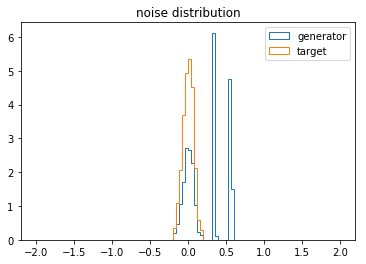

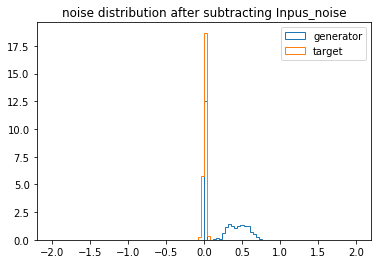

Time for epoch 10 is 38.16118502616882 sec,
Time for epoch 11 is 14.962159156799316 sec,
Time for epoch 12 is 15.052136659622192 sec,
Time for epoch 13 is 17.985139846801758 sec,
Time for epoch 14 is 14.976112365722656 sec,
Time for epoch 15 is 14.968385934829712 sec,
Time for epoch 16 is 18.670499086380005 sec,
Time for epoch 17 is 15.09671950340271 sec,
Time for epoch 18 is 15.164758443832397 sec,
Time for epoch 19 is 14.943576097488403 sec,


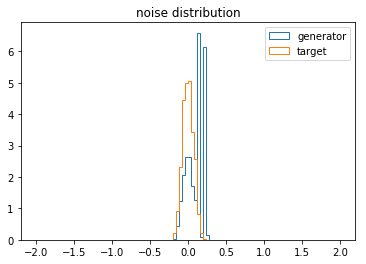

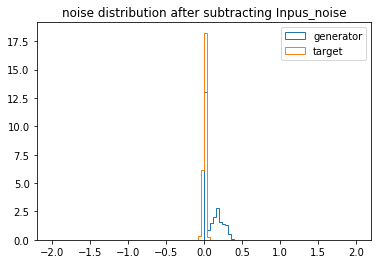

Time for epoch 20 is 36.50439167022705 sec,
Time for epoch 21 is 19.701951026916504 sec,
Time for epoch 22 is 15.030402421951294 sec,
Time for epoch 23 is 15.062240362167358 sec,
Time for epoch 24 is 15.011489629745483 sec,
Time for epoch 25 is 14.974858522415161 sec,
Time for epoch 26 is 20.955689907073975 sec,
Time for epoch 27 is 15.055284023284912 sec,
Time for epoch 28 is 15.125555753707886 sec,
Time for epoch 29 is 14.943682432174683 sec,


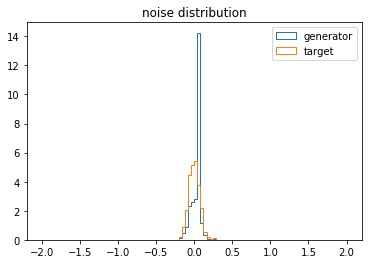

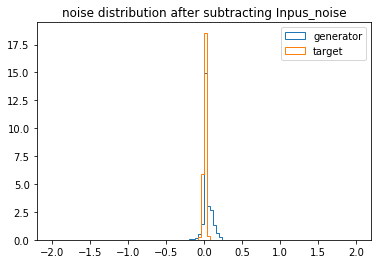

Time for epoch 30 is 36.590696811676025 sec,
Time for epoch 31 is 14.955691814422607 sec,
Time for epoch 32 is 22.097259283065796 sec,
Time for epoch 33 is 15.037519693374634 sec,
Time for epoch 34 is 14.942008972167969 sec,
Time for epoch 35 is 15.125877857208252 sec,
Time for epoch 36 is 15.022349119186401 sec,
Time for epoch 37 is 15.12036681175232 sec,
Time for epoch 38 is 15.069799184799194 sec,
Time for epoch 39 is 14.957912683486938 sec,


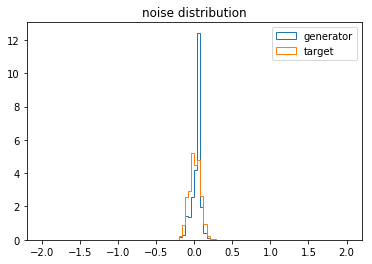

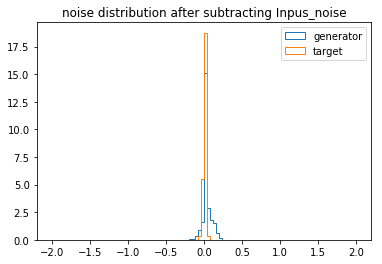

Time for epoch 40 is 36.447431564331055 sec,
Time for epoch 41 is 24.12458896636963 sec,
Time for epoch 42 is 15.045074462890625 sec,
Time for epoch 43 is 14.9608473777771 sec,
Time for epoch 44 is 14.827170848846436 sec,
Time for epoch 45 is 15.03155255317688 sec,
Time for epoch 46 is 15.023750305175781 sec,
Time for epoch 47 is 15.019654273986816 sec,
Time for epoch 48 is 15.33674955368042 sec,
Time for epoch 49 is 15.096758842468262 sec,


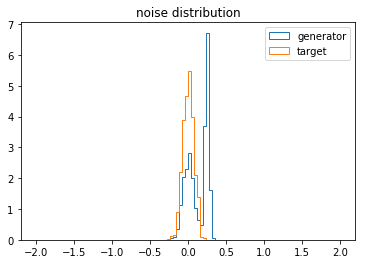

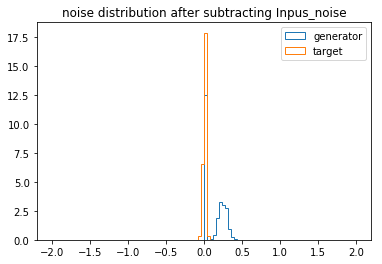

Time for epoch 50 is 36.485445976257324 sec,
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/saved_model/assets
Time for the training is 37.09860181808472 sec,
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  160       
_________________________________________________________________
dense_1 (Dense)              multiple                  1056      
_________________________________________________________________
dense_2 (Dense)              multiple                  64        
Total params: 1,280
Trainable params: 1,280
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_

In [16]:
%%time
train(epochs, steps_per_epoches , batch_size, generator, discriminator)

generator.summary()
discriminator.summary()

In [17]:
x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
#print(x)
real_c = real_channel(x)
fake_c = generator(x)

tf.debugging.check_numerics(fake_c,'message',name=None)

<tf.Tensor: id=4867069, shape=(5000, 2), dtype=float32, numpy=
array([[0.09113243, 0.4335232 ],
       [0.52123165, 0.22625467],
       [0.19421524, 0.56204015],
       ...,
       [0.03746897, 0.37884638],
       [0.1525234 , 0.02587807],
       [0.15718627, 0.05892387]], dtype=float32)>

## AE
Die Idee sollte sein das Training auf den encoder und decoder einzuschränken. Jedoch soll **end-to-end** trainiert werden, hierfür sollte vllt eine art Funktion eingesetzt werden, welche über die GAN's Layer zurück geht.
Muss ich hierfür die Layer nochmals einzeln definieren?


***Vermutung: Der Ausgang hat die 8fache dimension des Eingangs-> daher nur 1/8 richtig oder 7/8 richtig*** \\
**zu klären: was passiert in meinem AE dass sie dei dimension ver8-facht von (1000,8) zu (8000,n)**
**Kontrollieren was der output von meinem GAN ist**
**Add complexity for higher rubustness**




In [18]:


def get_encoder():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[M]))
  model.add(tf.keras.layers.Dense(M,use_bias=True, activation='relu'))
  model.add(tf.keras.layers.Dense(M,use_bias=True, activation='relu'))
  model.add(tf.keras.layers.Dense(n,use_bias=False, activation=None))
  model.add(tf.keras.layers.Lambda(lambda x : tf.divide(x, tf.sqrt(2*tf.reduce_mean(tf.square(x))))))
  return model

def get_decoder():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[n]))
  model.add(tf.keras.layers.Dense(n,use_bias=True, activation='relu'))
  model.add(tf.keras.layers.Dense(M,use_bias=True, activation='relu'))
  model.add(tf.keras.layers.Dense(M,use_bias=False, activation='softmax'))
  return model

encoder = get_encoder()
decoder = get_decoder()

encoder.summary()
generator.summary()
decoder.summary()
   
def get_AE(encoder, generator, decoder):
  AE_model = tf.keras.Sequential()
  AE_model.add(encoder)
  AE_model.add(tf.keras.layers.Lambda(generator))
  AE_model.add(decoder)
  return AE_model
          
    
def generate_data_vector(length):
  random_vector = tf.random.uniform(shape =(length,),minval=0,maxval=M, dtype=tf.dtypes.int32 ,seed=None,name=None)
  random_hot_one_vector = tf.one_hot(random_vector, depth=M,on_value=1, off_value=0,axis=-1)
  print(random_hot_one_vector.shape)
  return random_hot_one_vector

data, test_data = generate_data_vector(1000000), generate_data_vector(10000)
#print(data)

#model = Autoencoder()
AE = get_AE(encoder, generator, decoder)
AE.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = AE.fit(data, data, batch_size=1000,steps_per_epoch=2000, epochs=8)





  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 8         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              multiple                  0         
______________________________________

In [0]:
train_SNR_dB =8

def analytic_channel(input): 
  #print(input.shape)
  return input + tf.random.normal(tf.shape(input), mean=0.0, stddev=noise_std)

def real_transmision(test_data):
  y = encoder(test_data)
  y = generator(y)
  y = decoder(y)
  return y
  #model = tf.keras.Sequential()
  #model.add(encoder)
  #model.add(tf.keras.layers.Lambda(generator))
  #model.add(tf.keras.layers.Lambda(real_channel))
  #model.add(decoder)
  #return model

def test_diff_eval(test_data, results):
  diff = []
  for i in range(tf.shape(test_data)[0]):
    diff.append(tf.math.subtract(test_data[i,:], results[i,:]))
  return diff
    
  
real_AE = real_transmision(test_data)
testTest = tf.dtypes.cast(real_AE + tf.constant(0.1,dtype=tf.float32,shape=tf.shape(real_AE)), tf.int32)

diff_test =  test_diff_eval(test_data, testTest) 
#t = tf.math.subtract(test_data[1,:], real_AE[1,:])





In [20]:
print(sum(diff_test))

tf.Tensor([2517 2522 2482 2479], shape=(4,), dtype=int32)


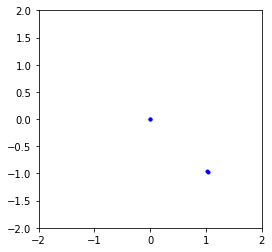

4


In [21]:
tes_data = np.eye(M, dtype = int)
coding= encoder.predict(tes_data)
fig = plt.figure(figsize=(4,4))
plt.plot(coding[:,0], coding[:,1],"b.")
plt.gca().set_ylim(-2,2)
plt.gca().set_xlim(-2,2)
plt.show()
print(M)

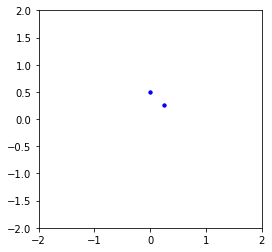

In [22]:
tes_data = np.eye(M, dtype = int)
coding= AE.predict(tes_data)
fig = plt.figure(figsize=(4,4))
plt.plot(coding[:,0], coding[:,1],"b.")
plt.gca().set_ylim(-2,2)
plt.gca().set_xlim(-2,2)
plt.show()

## Trainingparameters

In [0]:
train_EbNodB = 6
val_EbNodB = train_EbNodB

training_params = [
    #batch_size, lr, ebnodb, iterations
    [100    , 0.001, train_EbNodB, 1000],
    [100    , 0.0001, train_EbNodB, 10000],
    [1000    , 0.0001, train_EbNodB, 10000]
]

validation_params = [
    #batch_size, ebnodb, val_steps 
    [100000, val_EbNodB, 100],
    [100000, val_EbNodB, 1000],
    [100000, val_EbNodB, 1000]
]

## Create and train model

In [24]:
model_file_baseline = 'models/ae_baseline_k_{}_n_{}'.format(k,n)

ae_baseline = AE(k,n,useGAN=False,seed=seed)
ae_baseline.train(training_params, validation_params)

ae_baseline.save(model_file_baseline)

TypeError: ignored